In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import random
import numpy as np

In [3]:
# =========================================
# コイントス環境（多腕バンディット相当）— 説明コメント＋理論補足付き実装
# -----------------------------------------
# ・この環境は「行動 = コインの選択」「報酬 = 表が出たら1.0, 裏なら0.0」という
#   ベルヌーイ報酬の多腕バンディット（Bernoulli Multi-Armed Bandit）である。
# ・各コイン a に対して表の確率 p_a（head_probs[a]）が与えられる。
# ・各ステップで任意のコインを選び（pull）、報酬 r_t ~ Bernoulli(p_a) を得る。
# ・エピソードは max_episode_steps 回で終了（t=0..T-1 の T ステップ）。
# ・最適方策は、既知なら「最大の p_a をもつ腕を常に選択」になる（探索不要）。
#   しかし通常は p_a は未知であり、ε-greedy, UCB1, Thompson Sampling などで
#   「探索（exploration）」と「活用（exploitation）」のトレードオフを解く。
#
# 【理論的背景（要点）】
#   - 報酬生成：  r_t ~ Bernoulli(p_{a_t})
#   - 期待報酬：  E[r_t | a_t=a] = p_a
#   - 累積後悔：  Regret(T) = T * p_* - Σ_{t=1}^T E[r_t]
#       （p_* は最良腕の成功確率。探索で弱い腕を選ぶほど後悔が増える）
#   - 目的：T ステップでの期待累積報酬の最大化 ≒ 期待後悔の最小化
# =========================================

import random
from typing import List, Tuple


class CoinToss:
    """
    ベルヌーイ多腕バンディット環境。
    - head_probs[a]: 腕 a の成功確率 p_a （0.0〜1.0）
    - max_episode_steps: エピソードの長さ T
    """

    def __init__(self, head_probs: List[float], max_episode_steps: int = 30) -> None:
        # 各腕（コイン）の成功確率列。例: [0.1, 0.5, 0.8]
        self.head_probs: List[float] = head_probs
        # エピソード内で実行できる最大ステップ数（T）
        self.max_episode_steps: int = max_episode_steps
        # 現在のステップ数（0 始まり）
        self.toss_count: int = 0

    def __len__(self) -> int:
        # 腕（コイン）の本数を返す。学習アルゴリズムの初期化などで利用可能。
        return len(self.head_probs)

    # 追加：再現性確保のための乱数シード設定（任意）
    def seed(self, seed: int) -> None:
        """
        乱数のシードを固定することで実験再現性を高める。
        """
        random.seed(seed)

    def reset(self) -> None:
        """
        エピソードの開始時に呼ぶ。ステップカウンタを 0 に戻す。
        """
        self.toss_count = 0

    def step(self, action: int) -> Tuple[float, bool]:
        """
        1 ステップ実行：
        - 引数
            action: 選択する腕（コイン）のインデックス（0..N-1）
        - 戻り値
            (reward, done)
              reward: 表なら 1.0, 裏なら 0.0 のベルヌーイ報酬
              done  : エピソード終了なら True（t == T-1 の実行後）
        例外：
            - ステップ回数が上限を超えた場合
            - 不正な action（存在しない腕）
        """
        # --- エピソード長の境界チェック ---
        final = self.max_episode_steps - 1
        if self.toss_count < 0:
            raise Exception("Internal error: negative step count.")
        if self.toss_count > final:
            # 既に上限を超えている場合は reset 漏れを通知
            raise Exception("The step count exceeded maximum. Please reset env.")

        # --- 行動の妥当性チェック ---
        if not isinstance(action, int):
            raise Exception(f"Action must be int, got {type(action)}.")
        if action < 0 or action >= len(self.head_probs):
            raise Exception(f"The No.{action} coin doesn't exist.")

        # --- ベルヌーイ報酬のサンプリング ---
        head_prob = self.head_probs[action]  # 選んだ腕の成功確率 p_a
        reward = 1.0 if random.random() < head_prob else 0.0

        # --- ステップ進行と終端判定 ---
        # いまのステップで報酬を観測した後に toss_count を進める
        # （t=final の実行後に done=True を返す仕様）
        done = self.toss_count == final
        self.toss_count += 1

        return reward, done

In [4]:
# =========================================================
# ε-greedy エージェント（多腕バンディット）— 説明コメント＋理論補足付き
# ---------------------------------------------------------
# ・目的：複数の腕（コイン）から1つを選び、得られる報酬の期待値を最大化する。
# ・戦略：ε-greedy（確率 ε で探索、1-ε で現在の最良腕を活用）。
# ・環境：CoinToss などのベルヌーイ報酬バンディットを想定（len(env) で腕数取得、env.step(a) で報酬獲得）。
#
# 【理論背景（要点）】
#   - 観測モデル： r_t ~ Bernoulli(p_a)（腕 a の成功確率 p_a）
#   - 推定量：     各腕 a の価値推定 V[a] = これまでの平均報酬（漸次平均で更新）
#                   V_{n+1} = V_n + (1/(n+1)) * (r - V_n)
#   - 方策：       π(a|t) =
#                      ε / K           （K は腕数、探索時は一様に選ぶと仮定）
#                      1 - ε           （活用時は argmax_a V[a] を選択）
#   - 収束直感：   固定 ε > 0 では無限回の探索が起こるため、各腕の平均推定は強法則により真値へ近づく。
#                  ただし regret は O(T) に線形（最適ではない）。ε_t を減衰（例：ε_t = c/t）すると後悔が改善。
#   - 後悔：       Regret(T) = T * p_* - Σ_t E[r_t]（p_* は最良腕の成功確率）
#                  ε-greedy（固定ε）はシンプルで実装容易だが、UCB1/Thompson に比べ後悔上界は弱い。
# =========================================================

import random
from typing import List, Tuple, Optional
import numpy as np


class EpsilonGreedyAgent:
    """
    ε-greedy エージェント。
    - epsilon: 探索確率（0〜1）。高いほど探索を多く行い、低いほど現状の最良腕を活用する。
    - V: 各腕の推定価値（平均報酬）。play() 内で逐次更新する。
    """

    def __init__(self, epsilon: float) -> None:
        self.epsilon: float = float(epsilon)
        self.V: List[float] = []

    def seed(self, seed: int) -> None:
        """
        乱数シードを固定（再現性確保）。numpy と random の両方を固定する。
        """
        random.seed(seed)
        np.random.seed(seed)

    def policy(self) -> int:
        """
        ε-greedy 方策：
          - 確率 ε でランダム（探索）
          - それ以外は argmax V（活用）
        戻り値：選択した腕（インデックス）
        """
        coins = range(len(self.V))  # 腕の集合（0..K-1）
        if random.random() < self.epsilon:
            # 探索：一様にランダム選択
            return random.choice(list(coins))
        else:
            # 活用：推定価値が最大の腕（同値なら最初のインデックス）
            return int(np.argmax(self.V))

    def play(self, env) -> List[float]:
        """
        1 エピソード分プレイして報酬列を返す。
        想定する env インターフェース：
          - len(env)      → 腕の本数 K を返す
          - env.reset()   → エピソードのリセット
          - env.step(a)   → (reward: float, done: bool) を返す
        戻り値：各ステップでの観測報酬のリスト
        """
        # --- 初期化：各腕の試行回数 N と価値推定 V を 0 で開始 ---
        K = len(env)
        N: List[int] = [0] * K  # 各腕のプレイ回数
        self.V = [0.0] * K  # 各腕の平均報酬推定

        env.reset()
        done = False
        rewards: List[float] = []

        while not done:
            # 方策に従って腕（コイン）を選択
            selected_coin = self.policy()
            # 環境を1ステップ進め、報酬と終端フラグを取得
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            # --- 推定値の漸次更新（逐次平均） ---
            #  V_{n+1} = (n*V_n + r) / (n+1)
            n = N[selected_coin]
            coin_average = self.V[selected_coin]
            new_average = (coin_average * n + reward) / (n + 1)

            # カウントと推定値を更新
            N[selected_coin] += 1
            self.V[selected_coin] = new_average

        return rewards


# =========================
# 使用例（参考：コメントアウト）
# -------------------------
# from bandit_env import CoinToss
# env = CoinToss([0.2, 0.5, 0.8], max_episode_steps=100)
# agent = EpsilonGreedyAgent(epsilon=0.1)
# agent.seed(42)
# rewards = agent.play(env)
# print("平均報酬:", sum(rewards)/len(rewards))
# print("推定V:", agent.V)
# =========================

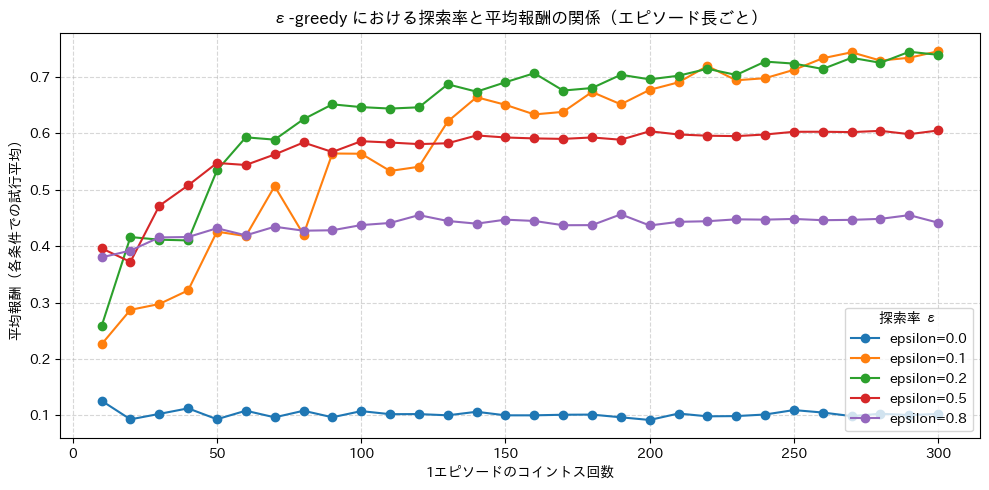

In [6]:
# =========================================
# ε-greedy の探索率と平均報酬（エピソード長の関数）の可視化
# -----------------------------------------
# ・目的：
#   - 異なる ε（探索率）に対して、エピソード長（投げる回数）が伸びると
#     平均報酬がどう変化するかを比較可視化する。
# ・理論背景（多腕バンディット）：
#   - 各腕 a の成功確率 p_a に対し、報酬 r_t ~ Bernoulli(p_{a_t}) を得る。
#   - ε-greedy 方策：確率 ε で探索、一方 1-ε で現在の推定最良腕を活用。
#   - 推定値更新は逐次平均：V_{n+1} = (n*V_n + r)/(n+1)。
#   - 固定 ε では無限に探索が続き一貫した推定が可能になるが、後悔は線形オーダ
#     （UCBやThompsonに比べ劣る）。ただし実装が非常に簡潔である。
# ・実装メモ：
#   - 元コードは「εごとに1つのエージェントを作り、エピソード長を変えながら連続実行」
#     していたため、推定 V が内側ループをまたいで“学習を持ち越す”バイアスがある。
#   - ここでは公正比較のため、各（ε, ステップ数）について **新しいエージェント** を作り直し、
#     n_trials 回の平均でノイズを低減する。
# =========================================

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# （任意）日本語フォント設定：ユーザ希望の既定設定
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

# 乱数の再現性確保
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ここでは、ユーザが既に定義済みの CoinToss, EpsilonGreedyAgent を使用する前提である。
# 例：
# class CoinToss: ...  # 前メッセージ参照
# class EpsilonGreedyAgent: ...  # 前メッセージ参照

# ----- 実験設定 -----
env = CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])  # 腕4が真の最良（p=0.9）
epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]  # 探索率の候補
game_steps = list(range(10, 310, 10))  # エピソード長（投げる回数）：10〜300
n_trials = 50  # 各条件での独立試行回数（平均で安定化）

# ----- 実験ループ -----
result = {}
for e in epsilons:
    means_per_len = []  # 各エピソード長における平均報酬
    for s in game_steps:
        env.max_episode_steps = s

        # 公正比較のため、この（ε, s）条件ごとに新しいエージェントを試行する。
        # さらに n_trials 回の平均で分散を下げる。
        trial_means = []
        for _ in range(n_trials):
            agent = EpsilonGreedyAgent(epsilon=e)
            agent.seed(np.random.randint(0, 10**9))  # 各試行でシードを変え軽い乱択
            rewards = agent.play(env)
            trial_means.append(float(np.mean(rewards)))

        means_per_len.append(float(np.mean(trial_means)))
    result[f"epsilon={e}"] = means_per_len

# 可読性のため、横軸のインデックス列を追加
result["coin toss count"] = game_steps

# ----- DataFrame 化と可視化 -----
df = pd.DataFrame(result).set_index("coin toss count", drop=True)

ax = df.plot.line(figsize=(10, 5), marker="o")
ax.set_title("ε-greedy における探索率と平均報酬の関係（エピソード長ごと）")
ax.set_xlabel("1エピソードのコイントス回数")
ax.set_ylabel("平均報酬（各条件での試行平均）")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(title="探索率 ε", loc="lower right")
plt.tight_layout()
plt.show()

# ----- 追加メモ（解釈指針）-----
# ・ε=0.0（純粋活用）は、初期推定が全て0のため最初の引き当て次第で弱い腕に固着しやすく、
#   エピソードが短いと平均報酬が伸びにくい傾向が出る。
# ・εが大きいほど探索は増え、短いエピソードでも最良腕に当たりやすいが、
#   長いエピソードでは無駄な探索が増えて上限が頭打ちになりやすい。
# ・中程度の ε（例：0.1〜0.2）は、短期の探索と長期の活用のバランスが良く、
#   本設定（最良腕 p=0.9）ではエピソード長が大きくなるほど平均報酬が高く収束していく傾向が期待される。